# Electrical Resistivity Tomography

Using the ert solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve the corresponding inverse problem.

{{ badge }}

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/environment.yml) file
specifies a list of packages required to run the notebooks)

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
# !MINICONDA_PREFIX=/usr/local
# !wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
# !chmod +x $MINICONDA_INSTALLER_SCRIPT
# !./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX
# !conda install -c gimli pygimli -y

# import sys
# _ = (sys.path.append("/usr/local/lib/python3.7/site-packages"))

We will need the following packages:

- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

Additionally, we wrap some `pygimli` code in file `pygimli_ert_lib.py` and import it
here for conciseness.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

from cofi import BaseProblem, InversionOptions, Inversion

from pygimli_ert_lib import *

np.random.seed(42)

## 1. Define the problem

We first define the true model, the survey and map it on a computational mesh designed for the survey and true anomaly.

Text(0.5, 1.0, 'Resitivity')

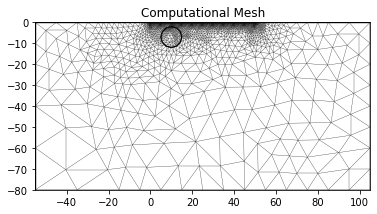

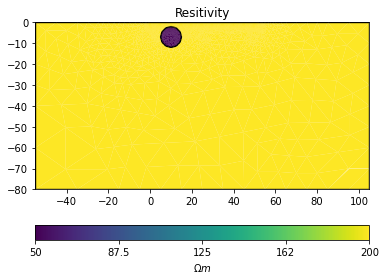

In [3]:
# PyGIMLi - define measuring scheme, geometry, forward mesh and true model
scheme = scheme_fwd()
geometry = geometry_true()
fmesh = mesh_fwd(scheme, geometry)
rhomap = markers_to_resistivity()
model_true = model_vec(rhomap, fmesh)

# plot the compuational mesh and the true model
ax=pg.show(fmesh)
ax[0].set_title("Computational Mesh")
ax=pg.show(fmesh,data=model_true,label=r"$\Omega m$")
ax[0].set_title("Resitivity")

Generate the synthetic data as a container with all the necessary information for plotting.

21/06/22 - 15:26:55 - pyGIMLi - INFO - Calculate geometric factors.


ModellingBase::setMesh() copying new mesh ... Found datafile: 51 electrodes
Found: 51 free-electrodes
rMin = 0.5, rMax = 100
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.038 s
FOP updating mesh dependencies ... 0 s
Obtaining geometric factors (analytical)
Calculating response for model: min = 50 max = 200
Allocating memory for primary potential...... 0.008

No primary potential for secondary field calculation. Calculating analytically...
Factorize (Cholmod) matrix ... 0.016
Factorize (Cholmod) matrix ... 0.013
Factorize (Cholmod) matrix ... 0.013
Factorize (Cholmod) matrix ... 0.013
Factorize (Cholmod) matrix ... 0.013
Factorize (Cholmod) matrix ... 0.013
Factorize (Cholmod) matrix ... 0.013
Factorize (Cholmod) matrix ... 0.013
Factorize (Cholmod) matrix ... 0.012
Factorize (Cholmod) matrix ... 0.012
Factorize (Cholmod) matrix ... 0.012
Factorize (Cholmod) matrix ... 0.012
Factorize (Cholmod) matrix ... 0.013
Factorize (Cholmod) matrix ... 0.01

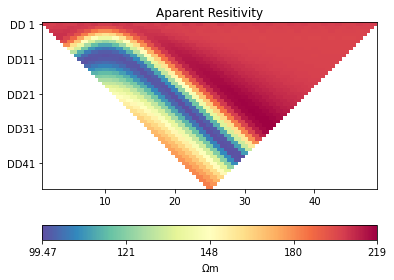

In [4]:
# PyGIMLi - generate data
survey = ert.simulate(fmesh, res=rhomap, scheme=scheme)

ax=ert.showERTData(survey,label=r"$\Omega$m")
ax[0].set_title("Aparent Resitivity")

y_obs = np.log(survey['rhoa'].array())

The inversion can use a different mesh and the mesh to be used should know nothing about the mesh that was designed based on the true model. We wrap two kinds of mesh as examples in the library code `pygimli_ert_lib.py`, namely triangular and rectangular mesh.

Use `imesh_tri = mesh_inv_triangular(scheme)` to initialise a triangular mesh, with the following optional arguments and corresponding default values:

- `start=[-15, 0]`
- `end=[65, -30]`

Use `imesh_rect = mesh_inv_rectangular()` to initislise a rectangular mesh, with the following optional arguments and corresponding default values:

- `x_start=-15`
- `x_stop=60`
- `x_num=11`
- `y_start=-30`
- `y_stop=0`
- `y_num=5`

Here we first demonstrate how to use a *triangular mesh*. Note that this makes the inversion problem under-determined.

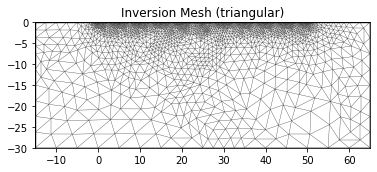

In [10]:
# PyGIMLi - quick demo of triangular mesh
imesh_tri = mesh_inv_triangular(scheme)

ax=pg.show(imesh_tri)
ax[0].set_title("Inversion Mesh (triangular)");

Check [here](https://github.com/inlab-geo/cofi-examples/tree/main/notebooks/pygimli_ert)
for inversion examples using triangular mesh.

For the purpose of this notebook, we use a *rectangular mesh* for a simple demonstration.

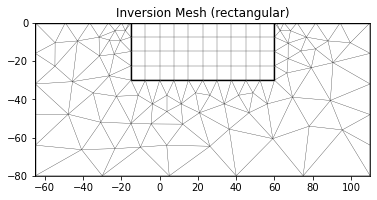

In [11]:
# PyGIMLi - create mesh for inversion
imesh = mesh_inv_rectangular()
ax = pygimli.show(imesh)
ax[0].set_title("Inversion Mesh (rectangular)");

With the inversion mesh created, we now define a starting model, forward operator and 
weighting matrix for regularisation using PyGIMLi.

In [13]:
# PyGIMLi - define the starting model on the inversion mesh
model_0 = starting_model(imesh)

# PyGIMLi - set up a forward operator with the inversion mesh
forward_operator = forward_oprt(scheme, imesh)

# PyGIMLi - extract the regularisation weighting matrix
Wm = weighting_matrix(forward_operator, imesh)

21/06/22 - 16:03:51 - Core - INFO - More than 50 regions, so we assume single regions only.
21/06/22 - 16:03:51 - Core - INFO - Applying *:* interregion constraints.


CoFI and other inference packages require a set of functions that provide the misfit, the jacobian the residual within the case of scipy standardised interfaces. All these functions are defined in the library file `pygimli_ert_lib.py`, so open this file if you'd like to find out the details. These functions are:

- `get_response`
- `get_jacobian`
- `get_residuals`
- `get_misfit`
- `get_regularisation`
- `get_gradient`
- `get_hessian`

With all the above forward operations set up with PyGIMLi, we now define the problem in `cofi`
by setting the problem information for a `BaseProblem` object.

In [24]:
# hyperparameters
lamda = 1

# cofi problem definition
ert_problem = BaseProblem()
ert_problem.name = "Electrical Resistivity Tomography defined through PyGIMLi"
ert_problem.set_forward(get_response, args=[forward_operator])
ert_problem.set_jacobian(get_jacobian, args=[forward_operator])
ert_problem.set_residual(get_residuals, args=[y_obs, forward_operator])
ert_problem.set_data_misfit(get_misfit, args=[y_obs, forward_operator, True])
ert_problem.set_regularisation(get_regularisation, lamda=lamda, args=[Wm, True])
ert_problem.set_gradient(get_gradient, args=[y_obs, forward_operator, lamda, Wm])
ert_problem.set_hessian(get_hessian, args=[y_obs, forward_operator, lamda, Wm])
ert_problem.set_initial_model(model_0)

Review what information is included in the `BaseProblem` object:

In [25]:
ert_problem.summary()

Summary for inversion problem: Electrical Resistivity Tomography defined through PyGIMLi
Model shape: (193,)
----------------------------------------------------------------------------------------
List of functions/properties set by you:
['gradient', 'hessian', 'residual', 'jacobian', 'data_misfit', 'regularisation', 'forward', 'initial_model', 'model_shape']
----------------------------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['objective', 'hessian_times_vector', 'jacobian_times_vector']
----------------------------------------------------------------------------------------
List of functions/properties not set by you:
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'hessian_times_vector', 'jacobian_times_vector', 'data', 'data_covariance', 'data_covariance_inv', 'walkers_starting_pos', 'blobs_dtype', 'bounds', 'constraints']


## 2. Define the inversion options and run

### 2.1 SciPy's optimiser ([L-BFGS-B](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb))

In [26]:
ert_problem.suggest_solvers();

Based on what you've provided so far, here are possible solvers:
{
    "optimisation": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares"
    ],
    "linear least square": [],
    "sampling": []
}


In [27]:
inv_options = InversionOptions()
inv_options.set_tool("scipy.optimize.minimize")
inv_options.set_params(method="L-BFGS-B")

Review what's been defined for the inversion we are about to run:

In [28]:
inv_options.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.optimize.minimize` - SciPy's optimisers that minimises a scalar function with respect to one or more variables, check SciPy's documentation page for a list of methods
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: 
method = L-BFGS-B
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [29]:
inv = Inversion(ert_problem, inv_options)
inv_result = inv.run()
inv_result.summary()

data misfit: 1330.5823132055143
raw regularisation: 0.0
data misfit: 1325.9161253098425
raw regularisation: 3.2377373769833095
data misfit: 1310.1261871672973
raw regularisation: 80.94343442458147
data misfit: 1322.2597025355954
raw regularisation: 10.893411257591398
data misfit: 1325.1353596470017
raw regularisation: 4.464129160381831
data misfit: 1325.7525438833811
raw regularisation: 3.477259459184535
data misfit: 1325.9161253098425
raw regularisation: 3.2377373769833095
data misfit: 1264.5224957842584
raw regularisation: 1012.8227161445419
data misfit: 1310.7004959099122
raw regularisation: 54.45085548727792
data misfit: 1322.561654493989
raw regularisation: 8.579849219838769
data misfit: 1325.2029179367073
raw regularisation: 4.127365486444092
data misfit: 1325.7658184451464
raw regularisation: 3.4144837115348308
data misfit: 1325.8845086408692
raw regularisation: 3.2744410940865567
data misfit: 1325.9094702083783
raw regularisation: 3.245433642602549
data misfit: 1325.91472615839

In [30]:
inv_result.success

True

Plot the results:

Text(0.5, 1.0, 'Inferred model')

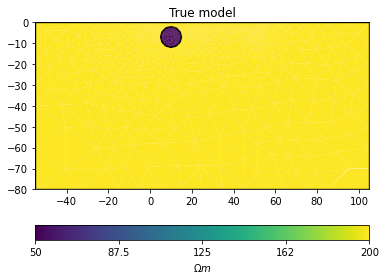

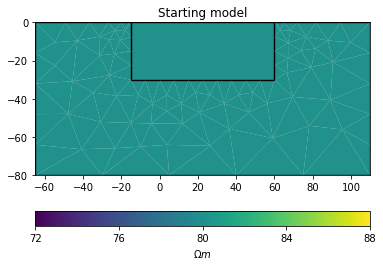

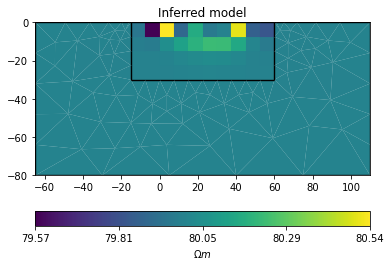

In [31]:
ax=pg.show(
    fmesh,
    data=(model_true),
    label=r"$\Omega m$"
)
ax[0].set_title("True model")

ax=pg.show(
    imesh,
    data=(model_0),
    label=r"$\Omega m$"
)
ax[0].set_title("Starting model")


ax=pg.show(
    imesh,
    data=(inv_result.model),
    label=r"$\Omega m$"
)
ax[0].set_title("Inferred model")

### 2.2 A custom [Newton's optimisation](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) approach

Now we switch to a Newton's iterative approach written by ourselves, so you'll 
have a closer look at what's happening in the loop.

First of all, define our own solver.

In [32]:
from cofi.solvers import BaseSolver

class MyNewtonSolver(BaseSolver):
    def __init__(self, inv_problem, inv_options):
        __params = inv_options.get_params()
        self._niter = __params["niter"]
        self._step = __params["step"]
        self._verbose = __params["verbose"]
        self._model_0 = inv_problem.initial_model
        self._gradient = inv_problem.gradient
        self._hessian = inv_problem.hessian
        self._misfit = inv_problem.data_misfit if inv_problem.data_misfit_defined else None
        self._reg = inv_problem.regularisation if inv_problem.regularisation_defined else None
        self._obj = inv_problem.objective if inv_problem.objective_defined else None
        
    def __call__(self):
        current_model = np.array(self._model_0)
        for i in range(self._niter):
            term1 = self._hessian(current_model)
            term2 = - self._gradient(current_model)
            model_update = np.linalg.solve(term1, term2)
            current_model = np.array(current_model + self._step * model_update)
            if self._verbose:
                print("-" * 80)
                print(f"Iteration {i+1}")
                if self._misfit: self._misfit(current_model)
                if self._reg: self._reg(current_model)
                # if self._obj: print("objective func:", self._obj(current_model))
        return {"model": current_model, "success": True}

Now, make use of this custom solver and run inversion again:

In [33]:
inv_options_own_solver = InversionOptions()
inv_options_own_solver.set_tool(MyNewtonSolver)
inv_options_own_solver.set_params(niter=100, step=1, verbose=True)

inv_own_solver = Inversion(ert_problem, inv_options_own_solver)
inv_own_solver_res = inv_own_solver.run()
inv_own_solver_res.summary()

--------------------------------------------------------------------------------
Iteration 1
data misfit: 1323.2573456559178
raw regularisation: 94.16649894082346
--------------------------------------------------------------------------------
Iteration 2
data misfit: 1317.427204890642
raw regularisation: 229.48696594206007
--------------------------------------------------------------------------------
Iteration 3
data misfit: 1312.3875580650779
raw regularisation: 369.5349582483292
--------------------------------------------------------------------------------
Iteration 4
data misfit: 1307.8671173437085
raw regularisation: 516.2014275638767
--------------------------------------------------------------------------------
Iteration 5
data misfit: 1303.7433130725524
raw regularisation: 670.4906915353556
--------------------------------------------------------------------------------
Iteration 6
data misfit: 1299.9466679121788
raw regularisation: 831.5092236936089
----------------------

Plot the results:

Text(0.5, 1.0, 'Inferred model')

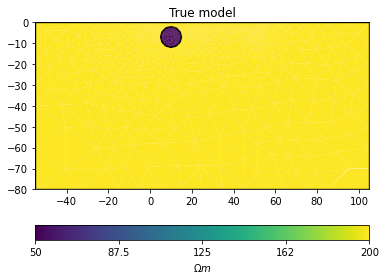

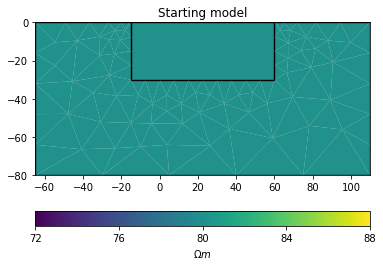

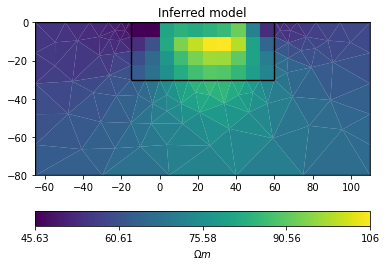

In [36]:
ax=pg.show(
    fmesh,
    data=(model_true),
    label=r"$\Omega m$"
)
ax[0].set_title("True model")

ax=pg.show(
    imesh,
    data=(model_0),
    label=r"$\Omega m$"
)
ax[0].set_title("Starting model")


ax=pg.show(
    imesh,
    data=(inv_own_solver_res.model),
    label=r"$\Omega m$"
)
ax[0].set_title("Inferred model")

### 2.3 Bayesian sampling with emcee (exploration)

CoFI needs more assumptions about the problem for a sampler to work - these are
the log of posterior distribution density and walkers' starting positions.

For the log posterior, we define here by specifying `log_prior` and `log_likelihood`.
And CoFI will combine them to get the `log_posterior`.

In [40]:
# hyperparameters
nwalkers = 32
nsteps = 10

# define log_likelihood
sigma = 1.0                                     # common noise standard deviation
Cdinv = np.eye(len(y_obs))/(sigma**2)           # inverse data covariance matrix
def log_likelihood(model):
    residual = ert_problem.residual(model)
    return -0.5 * residual @ (Cdinv @ residual).T

# define log_prior
m_lower_bound = np.zeros(model_0.shape)         # lower bound for uniform prior
m_upper_bound = np.ones(model_0.shape) * 250    # upper bound for uniform prior
def log_prior(model):                           # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

# define walkers' starting positions
walkers_start = model_0 + 1e-6 * np.random.randn(nwalkers, model_0.shape[0])

# define them into cofi's BaseProblem object
ert_problem.set_log_likelihood(log_likelihood)
ert_problem.set_log_prior(log_prior)
ert_problem.set_walkers_starting_pos(walkers_start)

As usual, specify how you'd like to run the inversion and run it.

In [41]:
# define inversion options
inv_options_emcee = InversionOptions()
inv_options_emcee.set_tool("emcee")
inv_options_emcee.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True)

from emcee.moves import GaussianMove
inv_options_emcee.set_params(moves=GaussianMove(1))

# run the inversion
inv_rect_emcee = Inversion(ert_problem, inv_options_emcee)
inv_rect_emcee_res = inv_rect_emcee.run()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:10<00:00,  7.08s/it]


Let's sub-sample 10 models from the posterior ensemble and plot them out.

You'll see that the results are not as good. That's because we've used only 32 walkers
and 10 sampling steps.

In [44]:
sampler = inv_rect_emcee_res.sampler

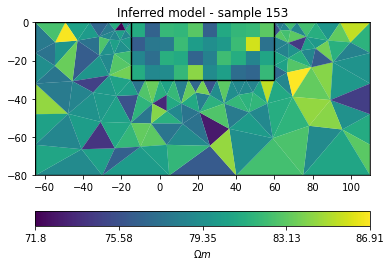

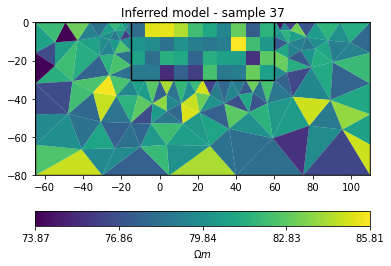

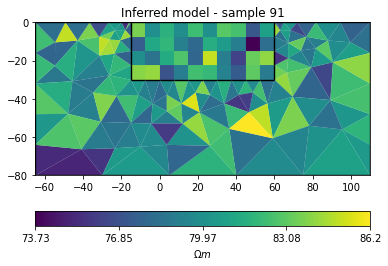

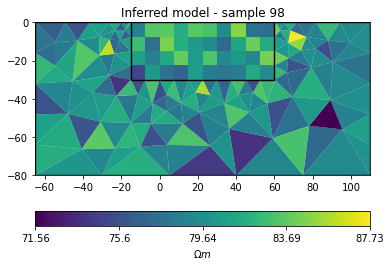

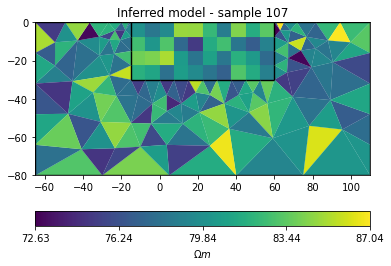

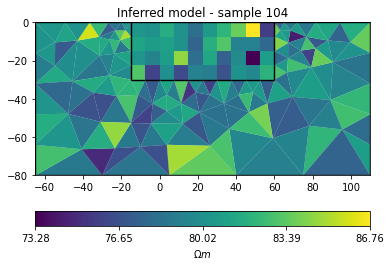

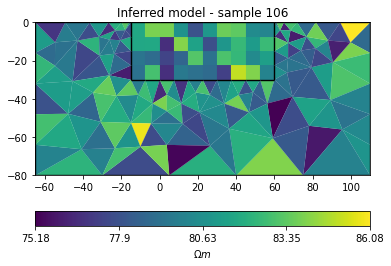

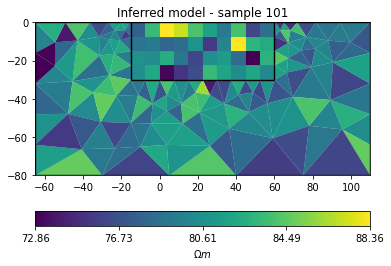

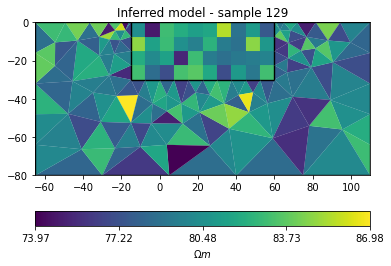

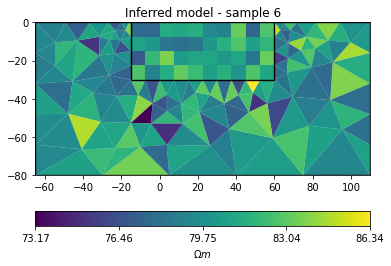

In [52]:
flat_samples = sampler.get_chain(discard=5, flat=True)
indices = np.random.randint(len(flat_samples), size=10) # get a random selection from posterior ensemble
for idx in indices:
    ax=pg.show(
        imesh,
        data=(flat_samples[idx]),
        label=r"$\Omega m$"
    )
    ax[0].set_title(f"Inferred model - sample {idx}")

Not satisfied with the results? Go back to the code cell under 2.3 and try with bigger numbers
of walkers and steps 😉